# <a title="Activity Recognition" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition - Video Dataset . Classifying the type of movement amongst six categories:
- Clapping,
- Meet and Spilt,
- Sitting,
- Standing Still,
- Walking While Reading Book,
- Walking While Using Phone.


## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of [feature vectors](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2) (one vector per [time step](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2)) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

> <a href="https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm" ><img src="https://raw.githubusercontent.com/Neuraxio/Machine-Learning-Figures/master/rnn-architectures.png" /></a>
> [Learn more on RNNs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)

## What is an LSTM?

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this course](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm) for you to learn more on LSTMs.

> [Learn more on LSTMs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
# All Includes
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.metrics import precision_score, accuracy_score, f1_score

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix

tf.config.optimizer.set_experimental_options({'auto_mixed_precision': False})
import warnings
warnings.filterwarnings("ignore")

2024-07-21 19:37:17.496950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 19:37:17.497005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 19:37:17.498523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Let's start by downloading the data: 

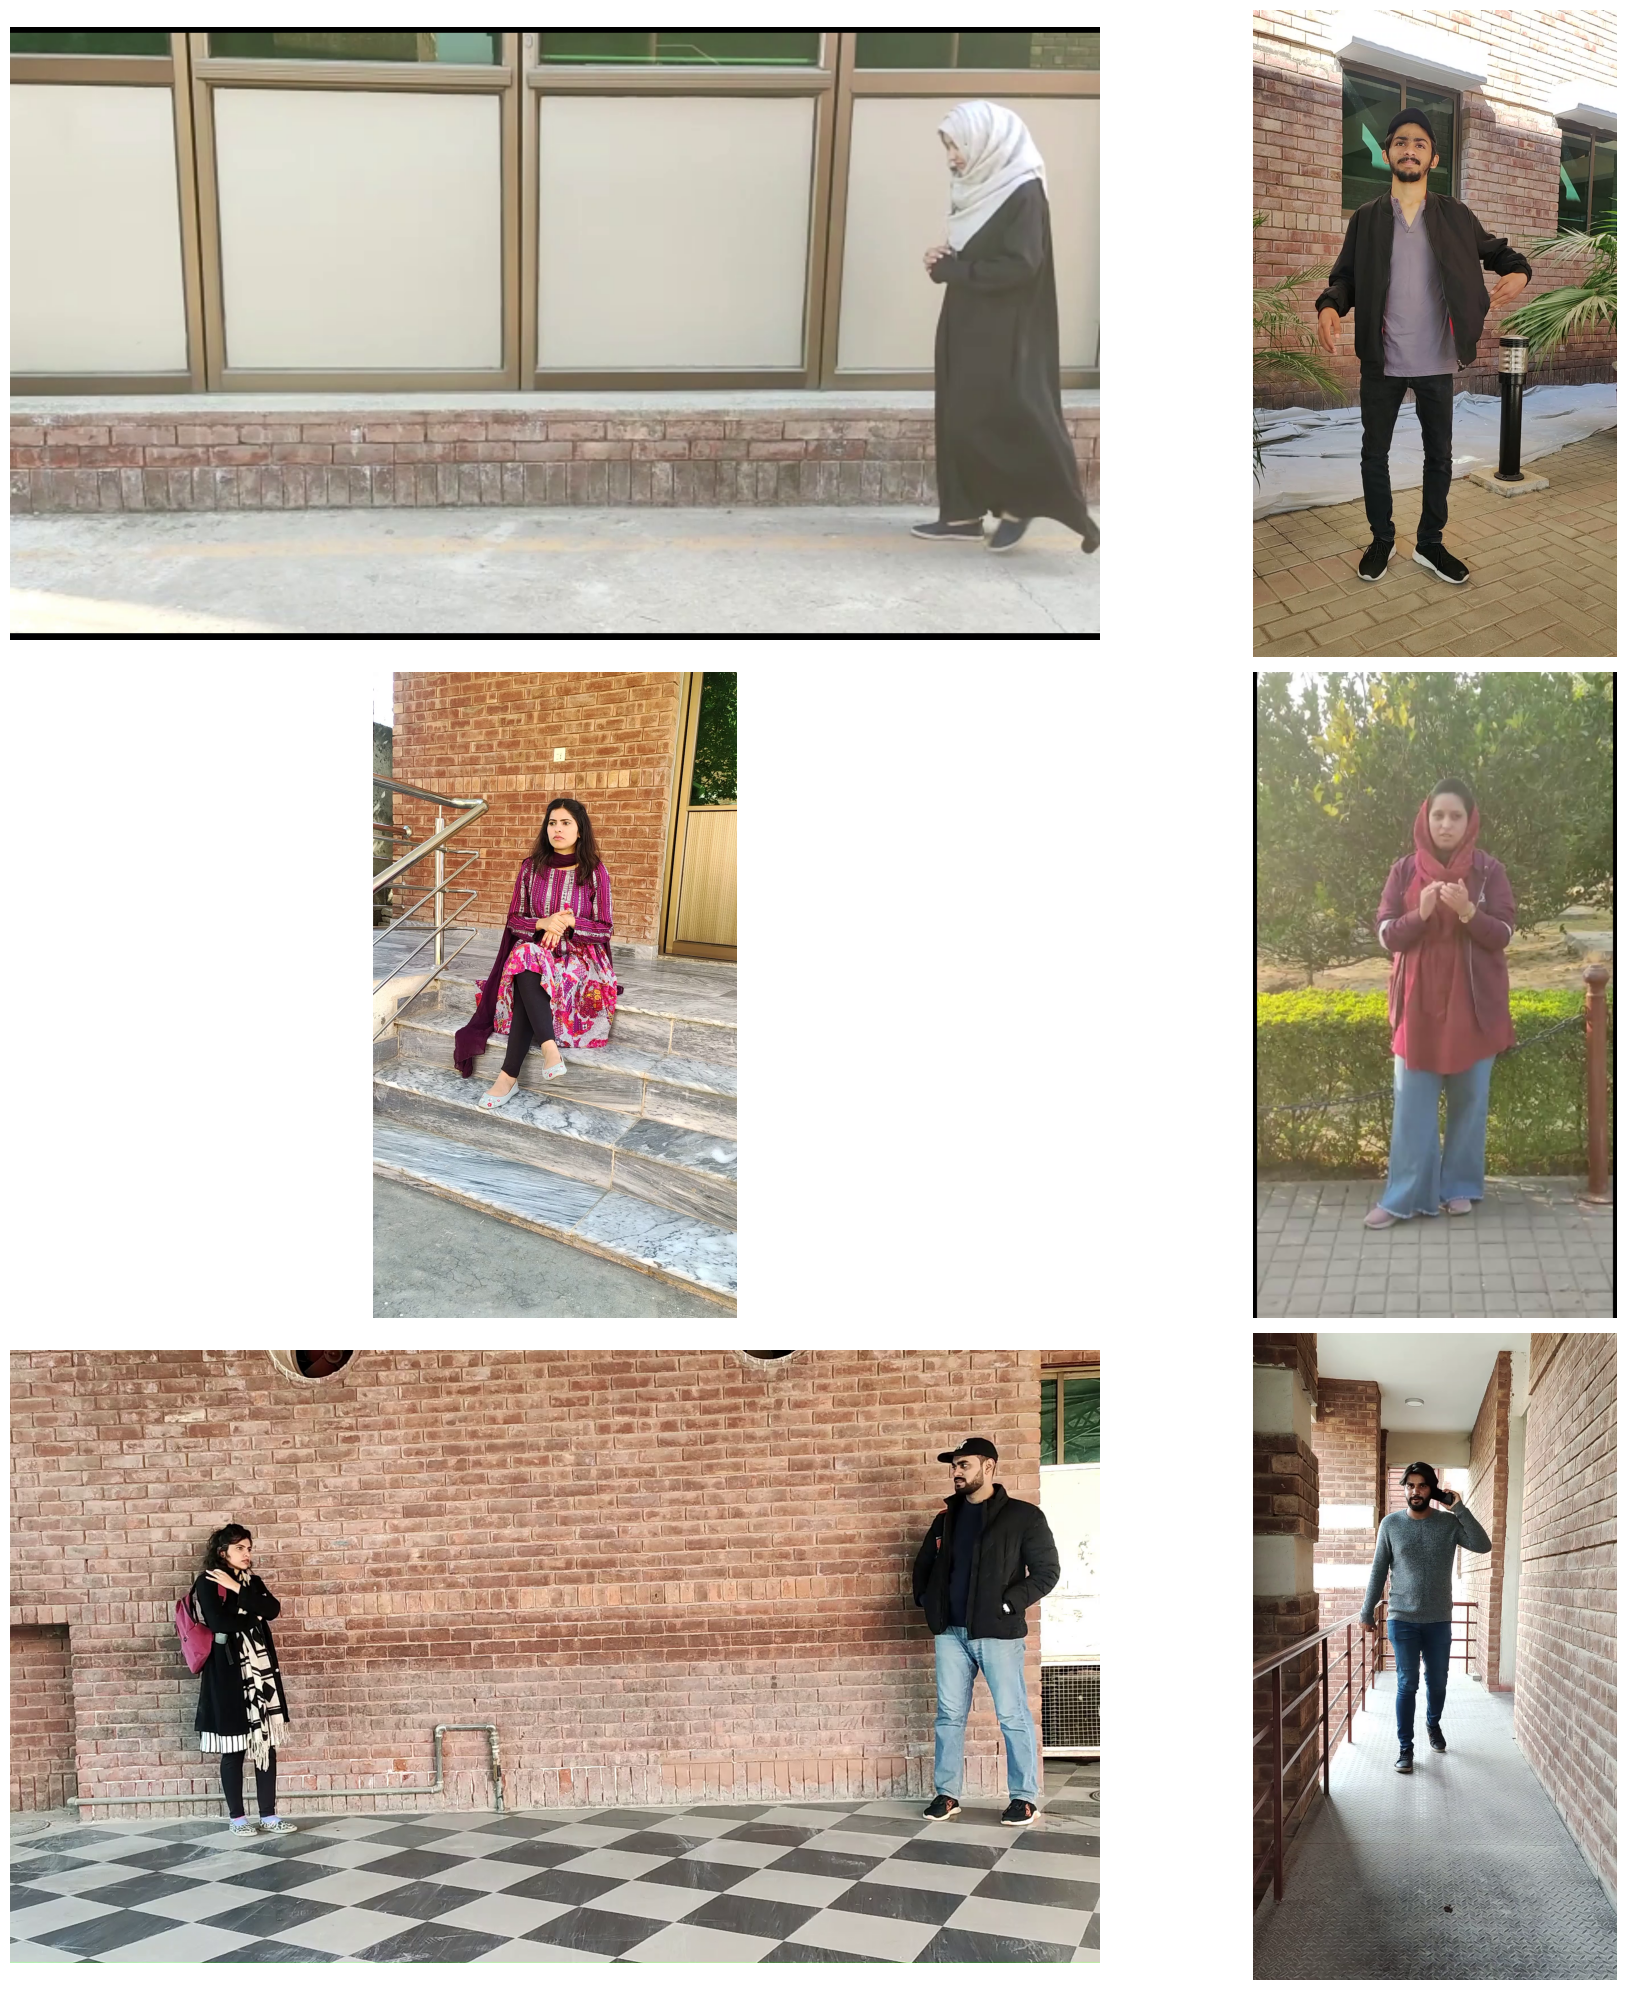

In [2]:


# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

all_classes_names = os.listdir('/kaggle/input/human-activity-recognition-video-dataset/Human Activity Recognition - Video Dataset')

random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/kaggle/input/human-activity-recognition-video-dataset/Human Activity Recognition - Video Dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/kaggle/input/human-activity-recognition-video-dataset/Human Activity Recognition - Video Dataset/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display the frame.
    plt.subplot(3, 2, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# Adjust the spacing between subplots.
plt.tight_layout()

# Show the plot with all the frames.
plt.show()

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*
**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/kaggle/input/human-activity-recognition-video-dataset/Human Activity Recognition - Video Dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['Clapping',
'Meet and Split',
'Sitting',
'Standing Still',
'Walking',
'Walking While Reading Book',
'Walking While Using Phone']

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [4]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [5]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Clapping
Extracting Data of Class: Meet and Split
Extracting Data of Class: Sitting
Extracting Data of Class: Standing Still
Extracting Data of Class: Walking
Extracting Data of Class: Walking While Reading Book
Extracting Data of Class: Walking While Using Phone


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [7]:

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [8]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)
print(f"Length of features: {len(features_train)}")
print(f"Length of labels: {len(features_test)}")
print(f"Length of video_files_paths: {len(labels_train)}")

Length of features: 834
Length of labels: 279
Length of video_files_paths: 834


### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category.

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [9]:

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()
    
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         recurrent_dropout=0.2, return_sequences=True, data_format="channels_last"))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))


#     # Display the models summary.
#     model.summary()

    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

Model Created Successfully!


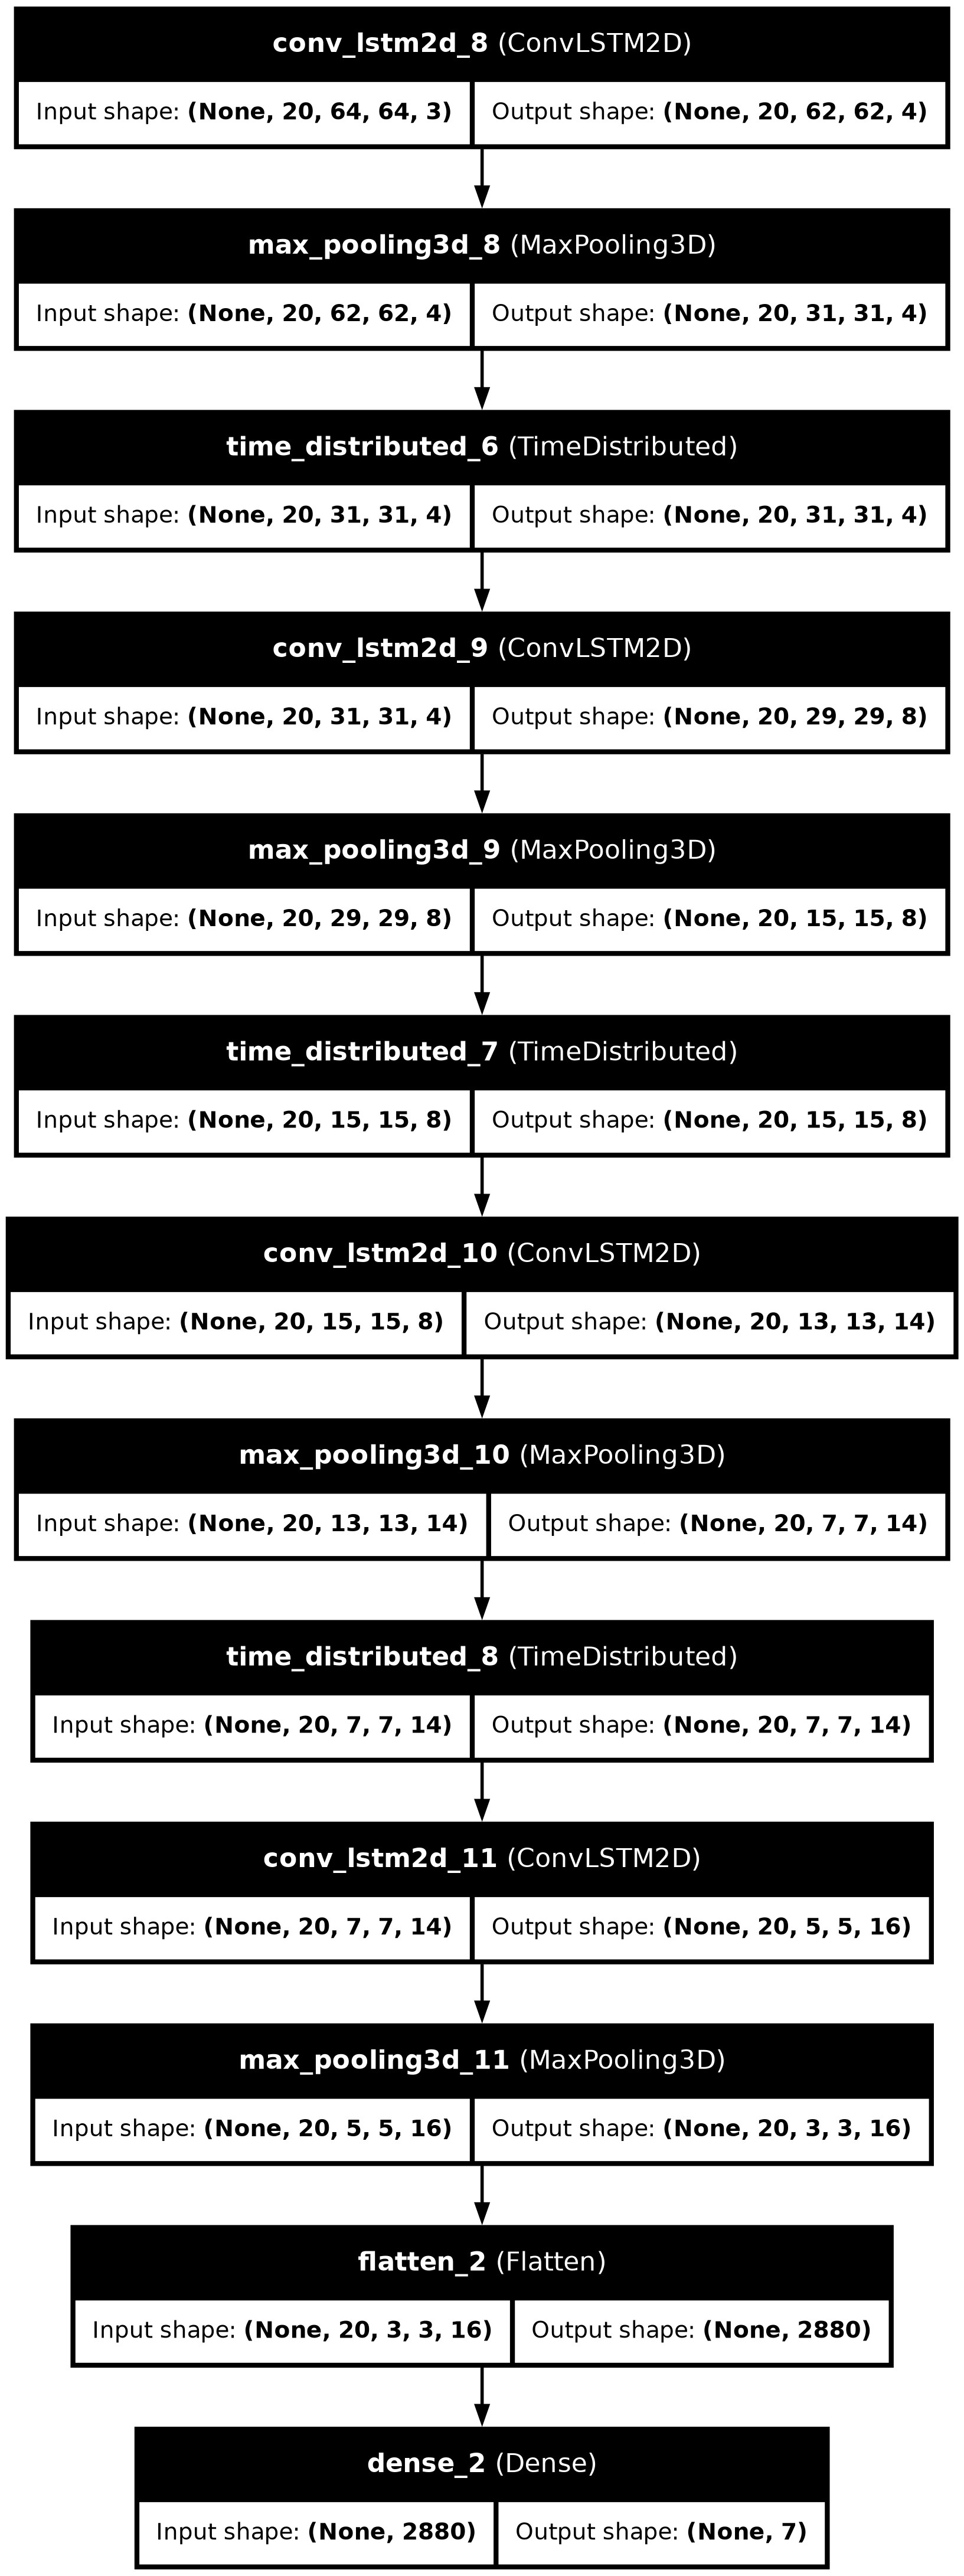

In [21]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")
# Draw the model architecture
plot_model(convlstm_model, to_file='convlstm_model.png', show_shapes=True, show_layer_names=True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [22]:
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': False})

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size =1,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.1931 - loss: 1.8769 - val_accuracy: 0.5150 - val_loss: 1.3018
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.6258 - loss: 1.0345 - val_accuracy: 0.7006 - val_loss: 0.8162
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.8257 - loss: 0.4638 - val_accuracy: 0.8204 - val_loss: 0.6642
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.9093 - loss: 0.2380 - val_accuracy: 0.8443 - val_loss: 0.4017
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9293 - loss: 0.1957 - val_accuracy: 0.8862 - val_loss: 0.3506
Epoch 6/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9621 - loss: 0.0824 - val_accuracy: 0.9042 - val_loss: 0.3207
Epoch 7/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.9622 - loss: 0.1080 - val_accuracy: 0.8743 - val_loss: 0.4166
Epoch 8/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9663 - loss: 0.1168 -

In [27]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8061 - loss: 0.8714


In [24]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

## And finally, the multi-class confusion matrix and metrics!

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8061 - loss: 0.8714
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Model Evaluation Loss: 0.7992119193077087
Model Evaluation Accuracy: 0.8207885026931763
Precision: 0.8390496105961622
Accuracy: 0.8243727598566308
F1 Score: 0.826144286311705


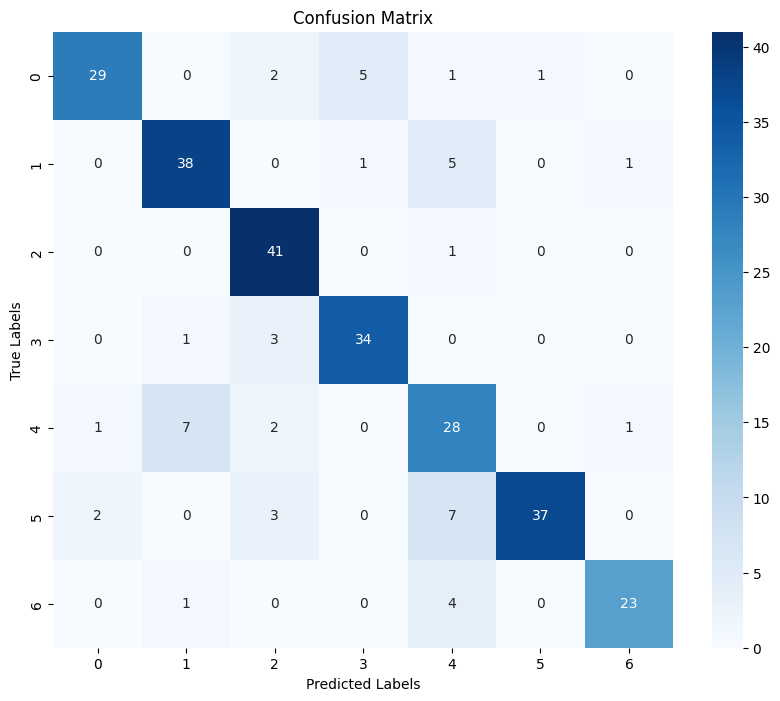

In [26]:

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Make predictions on the test set
y_pred = convlstm_model.predict(features_test)

# Convert predictions and true labels to one-hot encoded format if they are not already
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_test, axis=1)

# Calculate precision, accuracy, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Define the string date format.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss:.4f}___Accuracy_{accuracy:.4f}___Precision_{precision:.4f}___F1_{f1:.4f}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

# Print the metrics
print(f'Model Evaluation Loss: {model_evaluation_loss}')
print(f'Model Evaluation Accuracy: {model_evaluation_accuracy}')
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(len(np.unique(y_true_classes))),
            yticklabels=np.arange(len(np.unique(y_true_classes))))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
